Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Carpetas creadas: ['root', 'data', 'raw', 'clean', 'reports', 'config', 'portfolio']
✅ Cartera cargada desde Google Sheet: (21, 8)
✅ Catálogos cargados: ETFs ((4, 8)), Fondos ((2, 11))

=== 📋 TU CARTERA COMPLETA ===


,nombre,tipo,categoria,region,divisa_base,hedged,importe_actual_eur,peso_%
20,"ACN Bonus 220k$, otorgados OCT'24, por 350$/Ac...",Otros,Otros (RSU/Vesting),USA,USD,No,160000.0,18.10
2,AXA TRESOR COURT TERME C CAP EUR (CAIXA),Fondo,Fondo,OTROS,EUR,No,120000.0,13.57
1,Groupama Trésorerie,Fondo,Fondo,OTROS,EUR,No,120000.0,13.57
3,Neuberger Short Duration Euro Bond,Fondo,Fondo,OTROS,EUR,No,90000.0,10.18
0,NaN,Fondo,Fondo,OTROS,EUR,No,79127.0,8.95
19,"ACN Programa de Compra Mensual 5k/mes, 60 k/añ...",Otros,Otros (RSU/Vesting),USA,USD,No,60000.0,6.79
4,M&G European Credit Investment W (EUR) ACC,Fondo,Fondo,OTROS,EUR,No,50000.0,5.66
16,Cash,Cash,Cash,CASH,EUR,—,50000.0,5.66
17,Cash para Invertir en RV Core,Cash,Cash,CASH,EUR,—,42241.0,4.78
11,NaN,ETF,ETF,OTROS,EUR,No,30000.0,3.39



=== 🌍 EXPOSICIÓN POR REGIÓN ===


,importe_actual_eur,peso_%
region,,
OTROS,523725.2,59.24
USA,230141.4,26.03
CASH,93119.7,10.53
EUROPE,37038.0,4.19



=== 🏷️ EXPOSICIÓN POR CATEGORÍA ===


,importe_actual_eur,peso_%
categoria,,
Fondo,459127.0,51.94
Otros (RSU/Vesting),220000.0,24.89
Cash,93119.7,10.53
ETF,64598.2,7.31
Renta Variable,47179.4,5.34


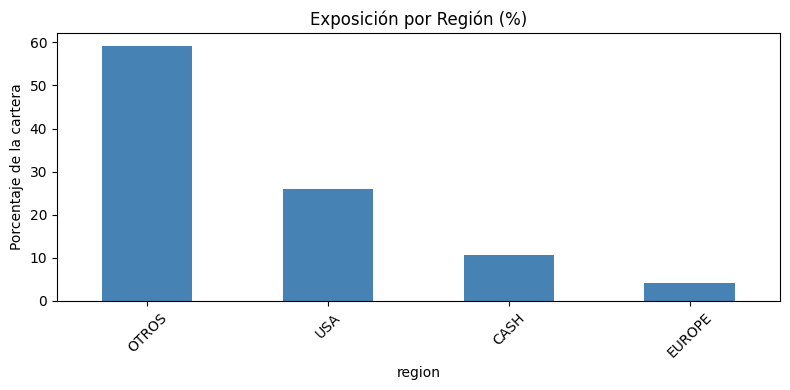

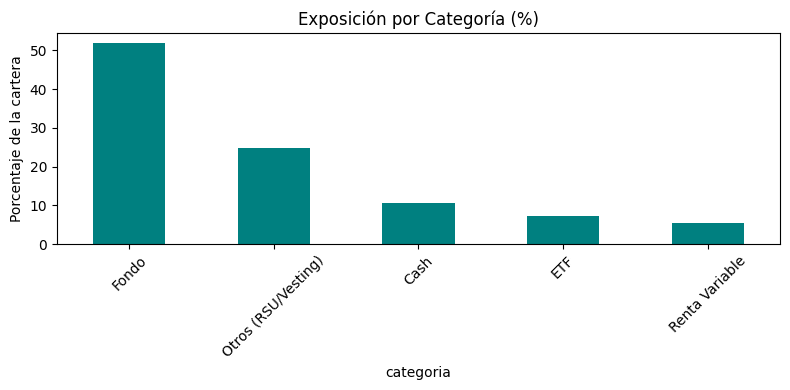


✅ Resultado guardado en: /content/drive/MyDrive/investment_ai/reports/portfolio_enriched_final.csv


In [ ]:
# ============================================
#Portfolio Exposure
#02_portfolio_exposure.ipynb - Portfolio desde Google Sheet
# ============================================

!pip -q install pandas openpyxl pyarrow gspread gspread-dataframe

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from google.colab import auth, drive
drive.mount('/content/drive', force_remount=False)
auth.authenticate_user()

import gspread
from google.auth import default
from gspread_dataframe import get_as_dataframe

creds, _ = default()
gc = gspread.authorize(creds)

# --- Rutas base ---
BASE = "/content/drive/MyDrive/investment_ai"
DIRS = {
    "root": BASE,
    "data": f"{BASE}/data",
    "raw": f"{BASE}/data/raw",
    "clean": f"{BASE}/data/clean",
    "reports": f"{BASE}/reports",
    "config": f"{BASE}/config",
    "portfolio": f"{BASE}/data/portfolio"
}

for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

print("✅ Carpetas creadas:", list(DIRS.keys()))

# --- Leer cartera desde Google Sheet ---
try:
    sh = gc.open("portfolio_holdings")
    ws = sh.sheet1  # o sh.worksheet("portfolio_holdings") si la pestaña tiene ese nombre
    pf = get_as_dataframe(ws, evaluate_formulas=True, header=0).dropna(how="all")
    print(f"✅ Cartera cargada desde Google Sheet: {pf.shape}")
except Exception as e:
    raise Exception(f"No se pudo abrir la hoja 'portfolio_holdings'. ¿Está el nombre correcto? Error: {e}")

# --- Leer catálogos desde Excel en Drive ---
CATALOG_XLSX = f"{DIRS['data']}/catalogs.xlsx"

if not os.path.exists(CATALOG_XLSX):
    raise FileNotFoundError(f"No encontré {CATALOG_XLSX}. Sube tu catalogs.xlsx a /data/")

etfs_catalog = pd.read_excel(CATALOG_XLSX, sheet_name="etfs_catalog")
funds_catalog = pd.read_excel(CATALOG_XLSX, sheet_name="funds_catalog")
print(f"✅ Catálogos cargados: ETFs ({etfs_catalog.shape}), Fondos ({funds_catalog.shape})")

# --- Limpiar cartera ---
pf.columns = [c.strip().lower().replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "") for c in pf.columns]
pf = pf.rename(columns={
    "producto_/_cuenta": "nombre",
    "importe_actual_(€)": "importe_actual_eur"
})

def clean_currency(x):
    if pd.isna(x): return 0.0
    s = str(x).replace("€", "").replace(" ", "")
    if re.search(r"\d+\.\d{3},\d{2}$", s):
        s = s.replace(".", "").replace(",", ".")
    else:
        s = s.replace(",", "")
    try:
        return float(s)
    except:
        return 0.0

pf["importe_actual_eur"] = pf["importe_actual_eur"].apply(clean_currency)
pf["ticker_yf"] = pf["ticker_yf"].astype(str).fillna("").str.strip()
pf["isin"] = pf["isin"].astype(str).fillna("").str.strip()
pf["tipo"] = pf["tipo"].astype(str).fillna("Otros")
pf["moneda"] = pf["moneda"].astype(str).fillna("EUR").str.upper()

# --- Normalizar catálogos ---
funds_catalog.columns = funds_catalog.columns.str.strip().str.lower()
funds_catalog["ticker_yf"] = funds_catalog["ticker_yf"].astype(str).str.strip()
funds_catalog["isin"] = funds_catalog["isin"].astype(str).str.strip()

etfs_catalog.columns = etfs_catalog.columns.str.strip().str.lower()
etfs_catalog["ticker"] = etfs_catalog["ticker"].astype(str).str.strip()
etfs_catalog["isin"] = etfs_catalog["isin"].astype(str).str.strip()

# --- Separar por tipo ---
pf_funds = pf[pf["tipo"].str.contains("Fondo", case=False, na=False)].copy()
pf_etfs  = pf[pf["tipo"].str.contains("ETF", case=False, na=False)].copy()
pf_acc   = pf[pf["tipo"].str.contains("Acción", case=False, na=False)].copy()
pf_cash  = pf[pf["tipo"].str.contains("Cash", case=False, na=False)].copy()
pf_otros = pf[~pf.index.isin(pf_funds.index.union(pf_etfs.index).union(pf_acc.index).union(pf_cash.index))].copy()

# --- Enriquecer Fondos (ISIN → ticker) ---
if not pf_funds.empty:
    orig_name = pf_funds["nombre"].copy()
    pf_funds = pf_funds.merge(
        funds_catalog.add_prefix("fund_"),
        left_on="isin", right_on="fund_isin", how="left"
    )
    missing = pf_funds["fund_isin"].isna() & pf_funds["isin"].notna()
    if missing.any():
        fallback = pf_funds[missing].merge(
            funds_catalog.add_prefix("fund_"),
            left_on="ticker_yf", right_on="fund_ticker_yf", how="left"
        )
        pf_funds.loc[missing, fallback.columns] = fallback.values
    pf_funds["nombre"] = orig_name

# --- Enriquecer ETFs (por ticker_yf) ---
if not pf_etfs.empty:
    orig_name = pf_etfs["nombre"].copy()
    pf_etfs = pf_etfs.merge(
        etfs_catalog.add_prefix("etf_"),
        left_on="ticker_yf", right_on="etf_ticker", how="left"
    )
    pf_etfs["nombre"] = orig_name

# --- Clasificar manualmente lo demás ---
stock_region_map = {
    "FOO": "USA",
    "ZEG": "EUROPE",
    "ASML": "EUROPE",
    "5DQ2y": "USA",
    "INRG.MI": "WORLD"
}
pf_acc["region"] = pf_acc["ticker_yf"].map(stock_region_map).fillna("USA")
pf_acc["divisa_base"] = pf_acc["moneda"]
pf_acc["hedged"] = "No"
pf_acc["categoria"] = "Renta Variable"

pf_cash["region"] = "CASH"
pf_cash["divisa_base"] = "EUR"
pf_cash["hedged"] = "—"
pf_cash["categoria"] = "Cash"

pf_otros["region"] = "USA"
pf_otros["divisa_base"] = "USD"
pf_otros["hedged"] = "No"
pf_otros["categoria"] = "Otros (RSU/Vesting)"

# --- Asegurar columnas comunes ---
common_cols = ["nombre", "tipo", "importe_actual_eur", "region", "divisa_base", "hedged", "categoria", "isin", "moneda", "ticker_yf"]

for df in [pf_funds, pf_etfs, pf_acc, pf_cash, pf_otros]:
    for col in common_cols:
        if col not in df.columns:
            df[col] = np.nan

# --- Unir todo ---
pf_all = pd.concat([
    pf_funds[common_cols],
    pf_etfs[common_cols],
    pf_acc[common_cols],
    pf_cash[common_cols],
    pf_otros[common_cols]
], ignore_index=True)

pf_all["region"] = pf_all["region"].fillna("OTROS")
pf_all["divisa_base"] = pf_all["divisa_base"].fillna(pf_all["moneda"])
pf_all["hedged"] = pf_all["hedged"].fillna("No")
pf_all["categoria"] = pf_all["categoria"].fillna(pf_all["tipo"])

total = pf_all["importe_actual_eur"].sum()
pf_all["peso_%"] = pf_all["importe_actual_eur"] / total * 100

# --- Mostrar resultados ---
print("\n=== 📋 TU CARTERA COMPLETA ===")
display(pf_all.sort_values("importe_actual_eur", ascending=False)[
    ["nombre", "tipo", "categoria", "region", "divisa_base", "hedged", "importe_actual_eur", "peso_%"]
].round(2))

print("\n=== 🌍 EXPOSICIÓN POR REGIÓN ===")
exp_region = pf_all.groupby("region")["importe_actual_eur"].sum().sort_values(ascending=False).to_frame()
exp_region["peso_%"] = exp_region["importe_actual_eur"] / total * 100
display(exp_region.round(2))

print("\n=== 🏷️ EXPOSICIÓN POR CATEGORÍA ===")
exp_cat = pf_all.groupby("categoria")["importe_actual_eur"].sum().sort_values(ascending=False).to_frame()
exp_cat["peso_%"] = exp_cat["importe_actual_eur"] / total * 100
display(exp_cat.round(2))

# --- Gráficos ---
plt.figure(figsize=(8, 4))
exp_region["peso_%"].plot(kind="bar", color="steelblue")
plt.title("Exposición por Región (%)")
plt.ylabel("Porcentaje de la cartera")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
exp_cat["peso_%"].plot(kind="bar", color="teal")
plt.title("Exposición por Categoría (%)")
plt.ylabel("Porcentaje de la cartera")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Guardar resultado ---
OUTPUT_PATH = f"{DIRS['reports']}/portfolio_enriched_final.csv"
pf_all.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ Resultado guardado en: {OUTPUT_PATH}")

Mounted at /content/drive
✅ Carpetas creadas: ['root', 'data', 'raw', 'clean', 'reports', 'config', 'portfolio']
✅ Cartera cargada desde Google Sheet: (21, 8)
✅ Catálogos cargados: ETFs ((4, 8)), Fondos ((2, 11))
⚠️ Tickers sin región asignada: {'5DQ2y', 'ASML', 'ZEG', 'FOO'}. Se asignarán a 'USA' por defecto.

=== 📋 TU CARTERA COMPLETA ===
                                                                               nombre    tipo            categoria region divisa_base hedged  importe_actual_eur  peso_%
20                    ACN Bonus 220k$, otorgados OCT'24, por 350$/Accion, Vested 2029   Otros  Otros (RSU/Vesting)    USA         USD     No            160000.0   18.10
2                                            AXA TRESOR COURT TERME C CAP EUR (CAIXA)   Fondo                Fondo  OTROS         EUR     No            120000.0   13.57
1                                                                 Groupama Trésorerie   Fondo                Fondo  OTROS         EUR     No          

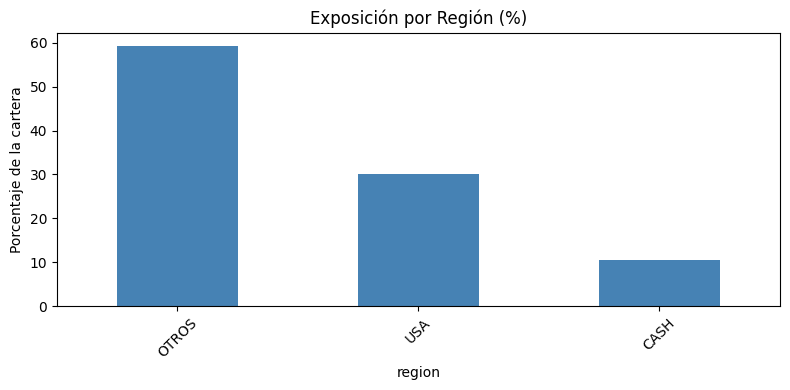

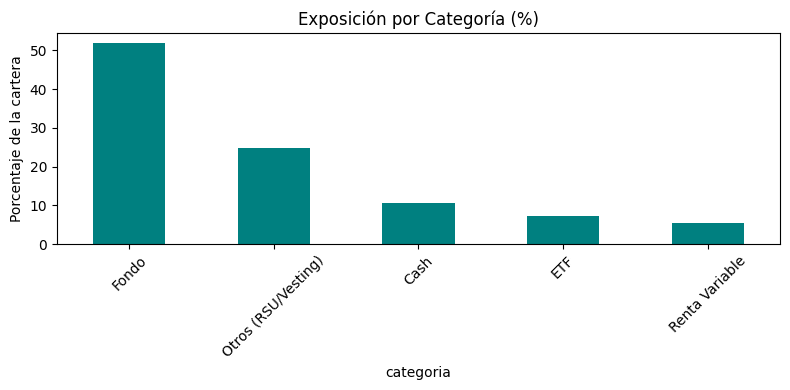


✅ Resultado guardado en: /content/drive/MyDrive/investment_ai/reports/portfolio_enriched_final.csv
✅ Resumen para orquestador: /content/drive/MyDrive/investment_ai/reports/portfolio_summary_latest.json


In [1]:
# ============================================
# Portfolio Exposure
# 02_portfolio_exposure.ipynb - Portfolio desde Google Sheet
# ============================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

# Instalación segura de dependencias
try:
    import gspread
    from gspread_dataframe import get_as_dataframe
except ImportError:
    !pip -q install pandas openpyxl pyarrow gspread gspread-dataframe
    import gspread
    from gspread_dataframe import get_as_dataframe

from google.colab import auth, drive
drive.mount('/content/drive', force_remount=False)
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

# --- Rutas base ---
BASE = "/content/drive/MyDrive/investment_ai"
DIRS = {
    "root": BASE,
    "data": f"{BASE}/data",
    "raw": f"{BASE}/data/raw",
    "clean": f"{BASE}/data/clean",
    "reports": f"{BASE}/reports",
    "config": f"{BASE}/config",
    "portfolio": f"{BASE}/data/portfolio"
}

for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

print("✅ Carpetas creadas:", list(DIRS.keys()))

# --- Leer cartera desde Google Sheet ---
try:
    sh = gc.open("portfolio_holdings")
    ws = sh.sheet1
    pf = get_as_dataframe(ws, evaluate_formulas=True, header=0).dropna(how="all")
    if pf.empty:
        raise ValueError("La hoja 'portfolio_holdings' está vacía.")
    print(f"✅ Cartera cargada desde Google Sheet: {pf.shape}")
except Exception as e:
    raise Exception(f"No se pudo abrir la hoja 'portfolio_holdings'. ¿Está el nombre correcto? Error: {e}")

# --- Leer catálogos desde Excel en Drive ---
CATALOG_XLSX = f"{DIRS['data']}/catalogs.xlsx"

if not os.path.exists(CATALOG_XLSX):
    raise FileNotFoundError(
        f"❌ No encontré 'catalogs.xlsx' en {DIRS['data']}. "
        "Por favor, sube tu archivo de catálogos a esa carpeta."
    )

etfs_catalog = pd.read_excel(CATALOG_XLSX, sheet_name="etfs_catalog")
funds_catalog = pd.read_excel(CATALOG_XLSX, sheet_name="funds_catalog")
print(f"✅ Catálogos cargados: ETFs ({etfs_catalog.shape}), Fondos ({funds_catalog.shape})")

# --- Limpiar cartera ---
pf.columns = (
    pf.columns
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("/", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
)
pf = pf.rename(columns={
    "producto_/_cuenta": "nombre",
    "importe_actual_(€)": "importe_actual_eur"
})

def clean_currency(x):
    if pd.isna(x): return 0.0
    s = str(x).replace("€", "").replace(" ", "")
    if re.search(r"\d+\.\d{3},\d{2}$", s):
        s = s.replace(".", "").replace(",", ".")
    else:
        s = s.replace(",", "")
    try:
        return float(s)
    except:
        return 0.0

pf["importe_actual_eur"] = pf["importe_actual_eur"].apply(clean_currency)
pf["ticker_yf"] = pf["ticker_yf"].astype(str).fillna("").str.strip()
pf["isin"] = pf["isin"].astype(str).fillna("").str.strip()
pf["tipo"] = pf["tipo"].astype(str).fillna("Otros")
pf["moneda"] = pf["moneda"].astype(str).fillna("EUR").str.upper()

# --- Normalizar catálogos ---
funds_catalog.columns = funds_catalog.columns.str.strip().str.lower()
funds_catalog["ticker_yf"] = funds_catalog["ticker_yf"].astype(str).str.strip()
funds_catalog["isin"] = funds_catalog["isin"].astype(str).str.strip()

etfs_catalog.columns = etfs_catalog.columns.str.strip().str.lower()
etfs_catalog["ticker"] = etfs_catalog["ticker"].astype(str).str.strip()
etfs_catalog["isin"] = etfs_catalog["isin"].astype(str).str.strip()

# --- Separar por tipo ---
pf_funds = pf[pf["tipo"].str.contains("Fondo", case=False, na=False)].copy()
pf_etfs  = pf[pf["tipo"].str.contains("ETF", case=False, na=False)].copy()
pf_acc   = pf[pf["tipo"].str.contains("Acción", case=False, na=False)].copy()
pf_cash  = pf[pf["tipo"].str.contains("Cash", case=False, na=False)].copy()
pf_otros = pf[~pf.index.isin(pf_funds.index.union(pf_etfs.index).union(pf_acc.index).union(pf_cash.index))].copy()

# --- Enriquecer Fondos (ISIN → ticker) ---
if not pf_funds.empty:
    orig_name = pf_funds["nombre"].copy()
    pf_funds = pf_funds.merge(
        funds_catalog.add_prefix("fund_"),
        left_on="isin", right_on="fund_isin", how="left"
    )
    missing = pf_funds["fund_isin"].isna() & pf_funds["isin"].notna()
    if missing.any():
        fallback = pf_funds[missing].merge(
            funds_catalog.add_prefix("fund_"),
            left_on="ticker_yf", right_on="fund_ticker_yf", how="left"
        )
        pf_funds.loc[missing, fallback.columns] = fallback.values
    pf_funds["nombre"] = orig_name

# --- Enriquecer ETFs (por ticker_yf) ---
if not pf_etfs.empty:
    orig_name = pf_etfs["nombre"].copy()
    pf_etfs = pf_etfs.merge(
        etfs_catalog.add_prefix("etf_"),
        left_on="ticker_yf", right_on="etf_ticker", how="left"
    )
    pf_etfs["nombre"] = orig_name

# --- Clasificar manualmente lo demás ---
stock_region_map = {
    "FOO.F": "USA",
    "ZEG.DE": "EUROPE",
    "ASML.AS": "EUROPE",
    "5DQ2.DU": "USA",
    "INRG.MI": "WORLD"
}
unknown_tickers = set(pf_acc["ticker_yf"]) - set(stock_region_map.keys())
if unknown_tickers:
    print(f"⚠️ Tickers sin región asignada: {unknown_tickers}. Se asignarán a 'USA' por defecto.")

pf_acc["region"] = pf_acc["ticker_yf"].map(stock_region_map).fillna("USA")
pf_acc["divisa_base"] = pf_acc["moneda"]
pf_acc["hedged"] = "No"
pf_acc["categoria"] = "Renta Variable"

pf_cash["region"] = "CASH"
pf_cash["divisa_base"] = "EUR"
pf_cash["hedged"] = "—"
pf_cash["categoria"] = "Cash"

pf_otros["region"] = "USA"
pf_otros["divisa_base"] = "USD"
pf_otros["hedged"] = "No"
pf_otros["categoria"] = "Otros (RSU/Vesting)"

# --- Asegurar columnas comunes ---
common_cols = ["nombre", "tipo", "importe_actual_eur", "region", "divisa_base", "hedged", "categoria", "isin", "moneda", "ticker_yf"]

for df in [pf_funds, pf_etfs, pf_acc, pf_cash, pf_otros]:
    for col in common_cols:
        if col not in df.columns:
            df[col] = np.nan

# --- Unir todo ---
pf_all = pd.concat([
    pf_funds[common_cols],
    pf_etfs[common_cols],
    pf_acc[common_cols],
    pf_cash[common_cols],
    pf_otros[common_cols]
], ignore_index=True)

pf_all["region"] = pf_all["region"].fillna("OTROS")
pf_all["divisa_base"] = pf_all["divisa_base"].fillna(pf_all["moneda"])
pf_all["hedged"] = pf_all["hedged"].fillna("No")
pf_all["categoria"] = pf_all["categoria"].fillna(pf_all["tipo"])

total = pf_all["importe_actual_eur"].sum()
if total == 0:
    raise ValueError("❌ El valor total de la cartera es 0. Revisa los importes en 'portfolio_holdings'.")

pf_all["peso_%"] = pf_all["importe_actual_eur"] / total * 100

# --- Mostrar resultados ---
print("\n=== 📋 TU CARTERA COMPLETA ===")
print(pf_all.sort_values("importe_actual_eur", ascending=False)[
    ["nombre", "tipo", "categoria", "region", "divisa_base", "hedged", "importe_actual_eur", "peso_%"]
].round(2).to_string())

print("\n=== 🌍 EXPOSICIÓN POR REGIÓN ===")
exp_region = pf_all.groupby("region")["importe_actual_eur"].sum().sort_values(ascending=False).to_frame()
exp_region["peso_%"] = exp_region["importe_actual_eur"] / total * 100
print(exp_region.round(2).to_string())

print("\n=== 🏷️ EXPOSICIÓN POR CATEGORÍA ===")
exp_cat = pf_all.groupby("categoria")["importe_actual_eur"].sum().sort_values(ascending=False).to_frame()
exp_cat["peso_%"] = exp_cat["importe_actual_eur"] / total * 100
print(exp_cat.round(2).to_string())

# --- Gráficos ---
plt.figure(figsize=(8, 4))
exp_region["peso_%"].plot(kind="bar", color="steelblue")
plt.title("Exposición por Región (%)")
plt.ylabel("Porcentaje de la cartera")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{DIRS['reports']}/portfolio_region.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 4))
exp_cat["peso_%"].plot(kind="bar", color="teal")
plt.title("Exposición por Categoría (%)")
plt.ylabel("Porcentaje de la cartera")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{DIRS['reports']}/portfolio_categoria.png", dpi=150)
plt.show()

# --- Guardar resultado ---
OUTPUT_PATH = f"{DIRS['reports']}/portfolio_enriched_final.csv"
pf_all.to_csv(OUTPUT_PATH, index=False)
pf_all.to_parquet(OUTPUT_PATH.replace(".csv", ".parquet"), index=False)

# Guardar resumen para orquestador
summary = {
    "fecha": pd.Timestamp.now().strftime("%Y-%m-%d"),
    "total_eur": float(total),
    "regiones": exp_region["peso_%"].round(2).to_dict(),
    "categorias": exp_cat["peso_%"].round(2).to_dict()
}
with open(f"{DIRS['reports']}/portfolio_summary_latest.json", "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n✅ Resultado guardado en: {OUTPUT_PATH}")
print(f"✅ Resumen para orquestador: {DIRS['reports']}/portfolio_summary_latest.json")